Detecting Signals in Noise using Short Fourier Transforms
========================================================

Clare's F23 thesis is on the analysis of Ligo data looking for signals at moderately high frequencies with a *slow* decrease in frequency but essentially constant amplitude. The method is described in the paper by Dergachev. That is hard to understand for a non-statistician so I want to explore some of the ideas.

The basic principle seems to be to come up with a set of candidate signals, 'templates', that are then fed one at a time, along the with the signal, into a process that generates a probability score. For each template treated individually you are trying to answer the question "how much signal power is there at the frequency of interest compared to the amount of noise in that same frequency bin". Because each template has an essentially constant amplitude and frequency over the duration of the data run all your interest is centered on a single, small, frequency domain that remains constant throughput the process of studying a single template.

It is worth noting that the fundamental assumption is that the signal is hidden in noise that is significantly larger than the signal and also that the available data will be in the form of short Fourier transforms of regions of the original signal. To make life more interesting, these regions may overlap or have gaps.

Why Short Fourier Transforms?
-----------------------------

If you have a lot of data why would you want to break up into many short pieces?

First, there may be instrumental reasons. A LIGO detector is an unbelievably complex system with a ridiculous number of failure points. For this reason you may simply not be able to take data continuously. In this case you will end up with a long sequence of data but broken up into fragments with gaps between. So long as you have a stable time reference this should not cause problems. You will know the exact time relationships between all pairs of fragments. But you can't just glue them together because there are gaps and those gaps will distort the signals if you just cut them out.

Second, there is a computational cost factor. The Fourier transform is intrinsically an expensive operation. The number of multiplies and adds that it takes to compute the transforms scales (for all but the smallest numbers of samples) as the square of the number of samples (but see The FFT below). Matrix multiplications similarly scale as the square of the dimension of the matrix while determinants and matrix inversions are even more costly, scaling roughly as the cube of the dimension.

Consider a long sample containing a total of $N\times{}M$ samples (we'll see why in a minute). The computational cost for taking the Fourier transform is then 
$$C_1\simeq{}k\times{}M^{2}\times{}N^{2}+c,$$
where $k$ involves the time for each operation and the number of operations per step and $c$ is a fixed cost. Since the interesting thing here is the power we normally say that the cost is of "order $M^{2}N^{2}$, written
$$C_1\sim{}O(M^{2}N^{2})$$.

By contrast, if we split the problem up into $M$ short transforms each of length $N$ then the computational cost falls to
$$C_M\sim{}O(M\times{}N^{2}),$$
a factor of $M$ faster.

For the kind of searches mentioned in the Phys. Rev. D paper $M$ is of order 1000 so that the SFT method is about a factor 1000 faster than a "fully coherent" search on a single sample containing the smae amount of data

The FFT
-------

Thanks to James W. Cooley and John W. Tukey, there is a faster way to compute discrete Fourier transforms. Their Fast Fourier Transform (FFT) method reduces the complexity from $O(n^{2})$ to $O(n\times{}\log{n})$. For this method of performing the transforms our example would see the cost shift from
$$C_{1}'\sim{}O(MN\log(MN))=O(MN[\log(M)+\log(N)])$$
to
$$C_{M}'\sim{}O(MN\log(N))$$
which is faster by rather more than a factor of M.

The Cost
--------

If short FFTs are so good then what are we worried about? 

First, the shorter FFTs have much poorer frequency resoution. The width of a frequency bin in the FFT is inversely proportional to the sample duration. Shorter samples means wider bins. If split a single record into 1000 shorter records then the frequency resolution of the SFTs is 1000x poorer than the original data. On the other hand, if we are trying to broaden our searches then wider bins are not necessarily a bad thing.

Second, we lose signal-to-noise with the shorter FFTs. If we take a total of $M$ runs each of $N$ samples from a single constant frequency signal with amplitude $A$ then the total power in the appropriate frequency bin from the full-length sample is $(MNA)^{2}=M^{2}N^{2}A^{2}$. However, the total power in the appropriate bin from a single short FFT is only $(NA)^{2}=N^{2}A^{2}$, a factor of $10^{6}$ less than the full sample in our example. But, you say, we have 1000 such SFTs so we can add the powers. However that will only recover $MN^{2}A^{2}$ so we are still a factor of 1000x less sensitive. Clearly the full information is still there (unlike the frequency discrimination information), we just have to figure out how to get it back.
This leads to the topic of this discussion, how do we recombine the M short FFTs so as to recover the full signal power that was present in the full-length FFT?

To answer this we will first build an example and see how good the full-length FFT is at detecting a signal in the presence of even large amounts of random noise. Then we shall see how much this suffers when we break the data up into many smaller segments and finally show how to reconstruct the original signal power.


Fourier and Noise
-----------------

The Fourier transform is instrically good at pulling signals of known frequency out of noise. We will start by looking at how this works in a simple trial system where we have a single constant amplitude sine wave buried in simple white noise.

Let's start with the obvious tools.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

Now I am going to create a starting signal. It will need to be long enough to chop up and still be able to FT sensibly. To get a bare hint I will start with 10,240 samples that I can chop up into frames of 1,024 samples for transforming. I am going to assume a sample rate of 10 ksps (lower than LIGO but not hugely) so that this is going to be 1.024 seconds of data.

For simplicity I make my starting signal of unit magnitude fixed frequency of 50 Hz in the signal array. Combined with the number means that the frames will not all start at the same point in the signal wave.

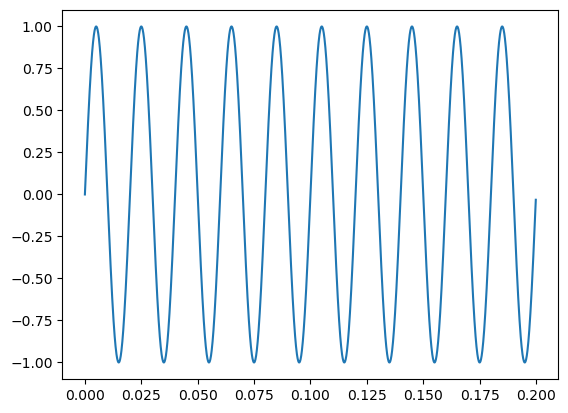

In [23]:
nPoint = 10_240
t = np.linspace(0, 1.024, nPoint, endpoint=False)
sig = np.sin(2 * np.pi * 50 * t)
plt.plot(t[:2000], sig[:2000])

This will have a very simple Fourier transform.

The frequencies will range from 0 (the average value) to the Nyquist frequency,
$$f_{Ny}=\dfrac{1}{2\Delta{}t},$$
where $\Delta{}t$ is the interval between samples. For us that will be 5 kHz.

The spacing between bins is given by
$$\delta{}f=\dfrac{1}{T},$$
where $T$ is the total time for the sample. For us that will be
$$\delta{}f=\dfrac{1}{1.024\,s}=0.98\,Hz.$$

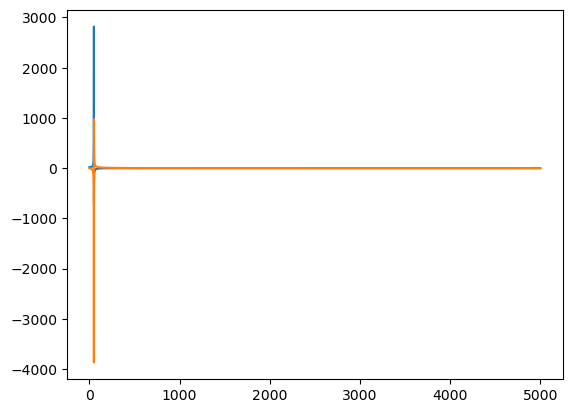

In [24]:
fft = np.fft.rfft(sig, axis=0)
freq = np.linspace(0, 5_000, int(nPoint/2) + 1)
plt.plot(freq, np.real(fft), freq, np.imag(fft))

There is a single clear peak but its position is hard to determine because it is so low. Let's blow up the bottom region.

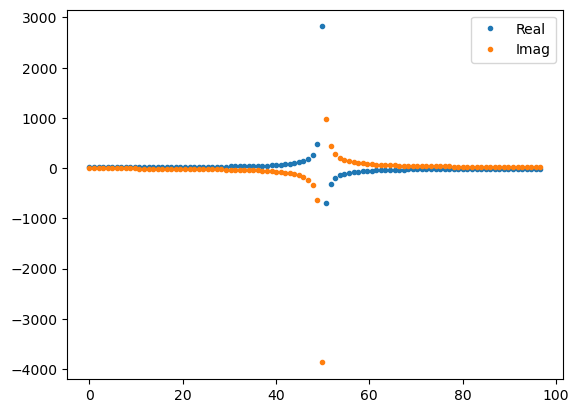

In [25]:
plt.plot(freq[:100], np.real(fft[:100]), '.', label='Real')
plt.plot(freq[:100], np.imag(fft[:100]), '.', label='Imag')
plt.legend()

We see a signal that is very strongly centered on 50 Hz but that has some slight leakage into the bins on either side. That is due partly to the finite length of the sample that we used but mostly to the fact that there are not an exact number of waves in the sample. We can see that if we look at the last few samples, remembering that the signal started at 0.

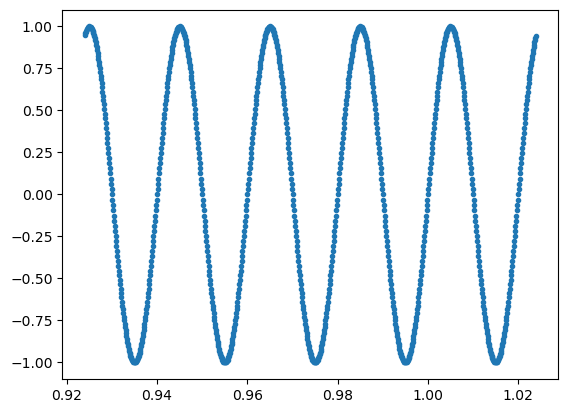

In [26]:
plt.plot(t[-1000:], sig[-1000:], '.')

Clearly we reached an integral number of periods at t=1.02 and we have an extra few samples in our wave.

Adding Noise in the Time Domain
-------------------------------

OK, so now what happens if we try to hide that signal in some noise?

I know from experience that our eye is good at finding sine waves even in the presence of quite a lot of noise so
let's start with noise that has the ten times the overall range of the signal so we have a 1:10 signal to noise ratio (SNR).

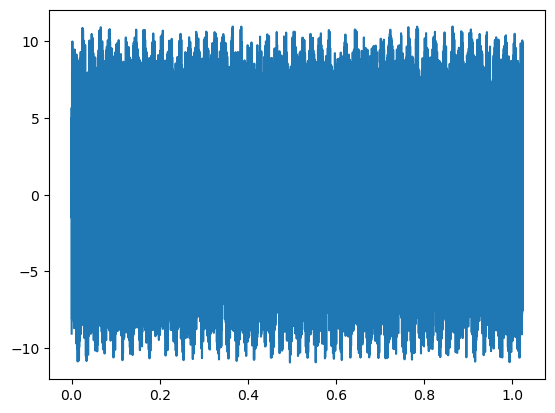

In [27]:
rng = np.random.default_rng()
noise = rng.uniform(low=-10.0, high=10.0, size=nPoint)
snp1 = sig + noise
plt.plot(t, snp1)

So at a signal-to-noise ratio of 1:10 we can just about see the signal with our eyes. Doing the same fourier analysis we get

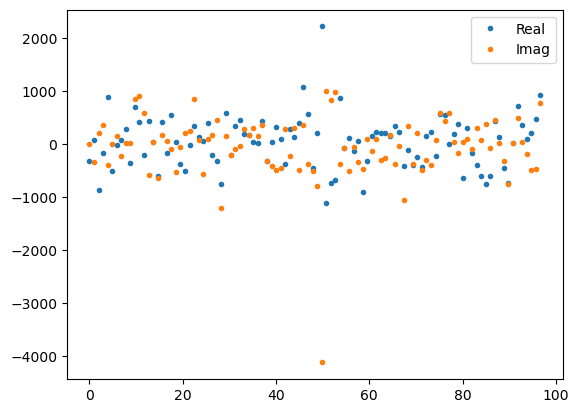

In [28]:
fftnp1 = np.fft.rfft(snp1, axis=0)
plt.plot(freq[:100], np.real(fftnp1[:100]), '.', label='Real')
plt.plot(freq[:100], np.imag(fftnp1[:100]), '.', label='Imag')
plt.legend()

or, plotting the magnitude for ease of view,

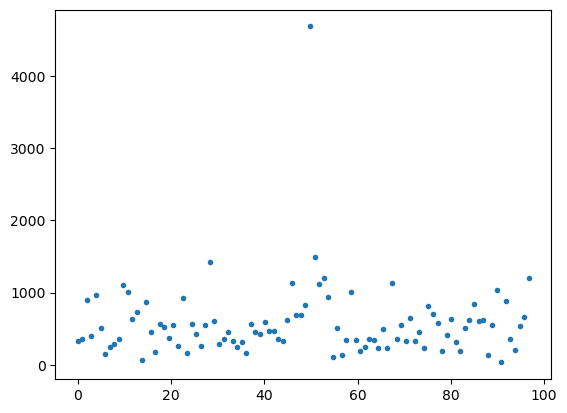

In [29]:
plt.plot(freq[:100], np.absolute(fftnp1[:100]), '.')

and we see clearly how the Fourier transform has resolved the signal well above the noise. In the signal domain we had a SNR of 1/10=0.1. In the Fourier domain we have signal+noise at around 5000 units compared to noise with a standard deviation ~<1000 for an SNR ~ 4. This is the power of the Fourier transform for pulling a signal out of noise.

Short Fourier Transforms
------------------------

What happens if we repeat our analysis using 10 short (1024 sample) transforms instead of the single long transform?

Well, first we are going to need a shorter frequency list since there will be only 1/10 as many frequency samples and thus the frequency bins will be 10 as wide, $9.8\,Hz$.

In [30]:
csig = sig.copy()
#frames = np.reshape(csig, (1024, 10))
frames = np.zeros((1024, 10))
for f in range(10):
    frames[:,f] = csig[1024*f:1024*(f+1)]
sfts = np.fft.rfft(frames, axis=0)
sfreq = np.linspace(0, 5_000, int(nPoint/20) + 1)

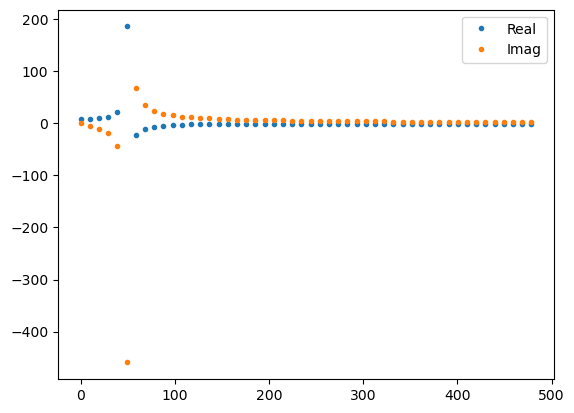

In [31]:
plt.plot(sfreq[:50], np.real(sfts[:50, 0]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts[:50, 0]), '.', label='Imag')
plt.legend()

As expected, we see leakage into much more remote frequency bins because of the shorter sample. Let's look at the next SFT.

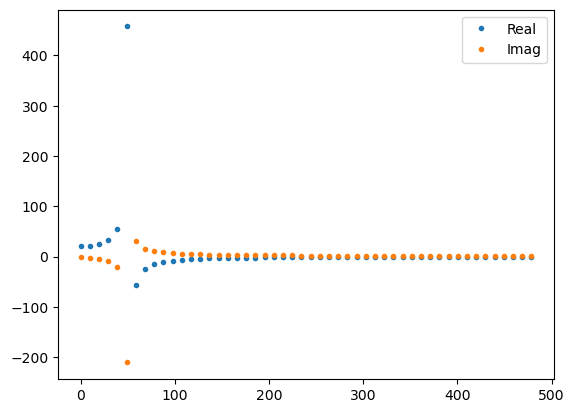

In [32]:
plt.plot(sfreq[:50], np.real(sfts[:50, 1]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(sfts[:50, 1]), '.', label='Imag')
plt.legend()

Hm, the spike is in exactly the same place but the real and imaginary parts have altered significantly. We can see the cause of this if we look at the two signals.

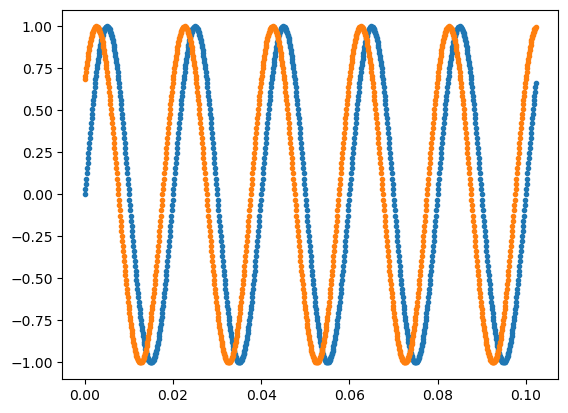

In [33]:
plt.plot(t[:1024], frames[:,0],'.')
plt.plot(t[:1024], frames[:,1],'.')

There we see how the phase of the signal drifts from one sub-sample to the next. This drift complicates the problem of combining the results from the sub-samples to recover a low-resolution version of the full transform.

Here is what we get if we simply sum the transforms.

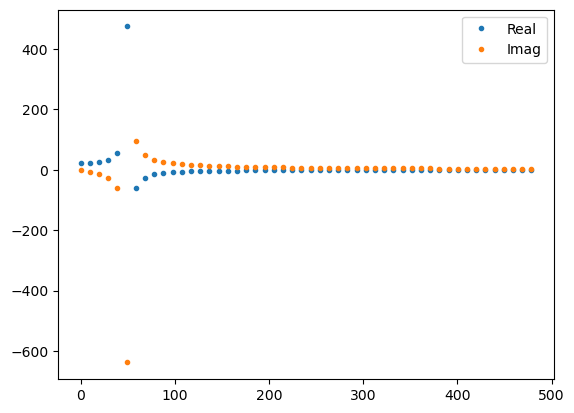

In [34]:
fsums = sfts[:, 0]
for i in range(9):
    fsums += sfts[:, i+1]
plt.plot(sfreq[:50], np.real(fsums[:50]), '.', label='Real')
plt.plot(sfreq[:50], np.imag(fsums[:50]), '.', label='Imag')
plt.legend()

or, plotting the magnitude again,

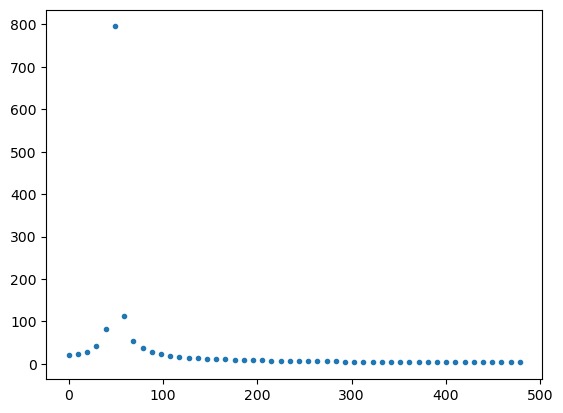

In [35]:
plt.plot(sfreq[:50], np.absolute(fsums[:50]),'.')

Well, the peak is in the right place but it much smaller than the peak in the full transform (Imax\~800 compared to Imax\~5000). This is more than the 500 that we might expect from the simple incoherent addition discussed above but it is still a large loss compared to the full FFT.

This is because we have been adding complex values with rather different phases and are seeing something between constructive and destructive interference. We can visualise the effect if we look at the individual 50 Hz signals in the complex plane (Argand diagram).

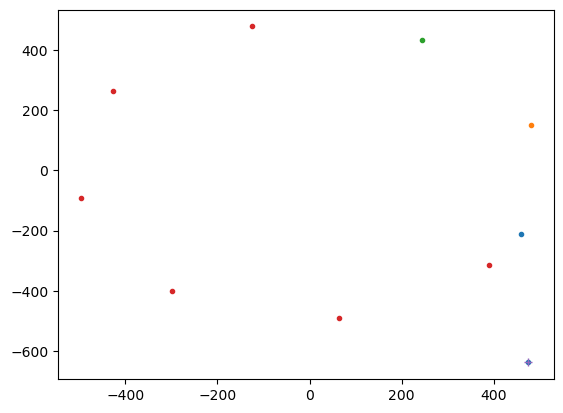

In [36]:
plt.plot(np.real(sfts[5, 0:2]), np.imag(sfts[5, 0:2]), '.')
plt.plot(np.real(sfts[5, 2:3]), np.imag(sfts[5, 2:3]), '.')
plt.plot(np.real(sfts[5, 3:4]), np.imag(sfts[5, 3:4]), '.')
plt.plot(np.real(sfts[5, 4:10]), np.imag(sfts[5, 4:10]), '.')
plt.plot(np.real(fft[50]), np.imag(fft[50]), '+')

I am not clear what is wrong with the bottom right point (which is the first point and has always appeared to have something wrong with it) but the rest are rotating around in a circle about the origin as the phase drift grows linearly in time.

Equation 78 in Riles shows us how we should sum the Fourier components from successive frames in order to get coherent summation. The phase for the i'th segment is moved forward by an amount $\phi(\omega)_{i}=\omega{}t_{i}$ so it is necessary to shift each sement's phase backward by that amount. Note that this value is different for every bin the Fourier transform since each represents a different frequency and thus a different phase shift.

Let's see it work

In [37]:
w = 2 * np.pi * 50
phi = np.zeros(10)
ephi = np.zeros(10, dtype=complex)
for i in range(10):
    phi[i] = w * t[1024 * i]
    ephi[i] = np.exp(-1.0J * phi[i])
    print(phi[i], ephi[i])

0.0 (1+0j)
32.169908772759484 (0.7289686274214104-0.6845471059286898j)
64.33981754551897 (0.06279051952931021-0.9980267284282718j)
96.50972631827845 (-0.6374239897486934-0.7705132427757861j)
128.67963509103794 (-0.9921147013144787-0.12533323356429793j)
160.8495438637974 (-0.8090169943749511+0.587785252292468j)
193.0194526365569 (-0.18738131458571528+0.9822872507286905j)
225.18936140931638 (0.535826794978994+0.8443279255020167j)
257.3592701820759 (0.9685831611286343+0.24868988716484247j)
289.5291789548354 (0.8763066800438362-0.4817536741017652j)


Next we multiply each of our 50 Hz Fourier coefficients by the phase factor and replot.

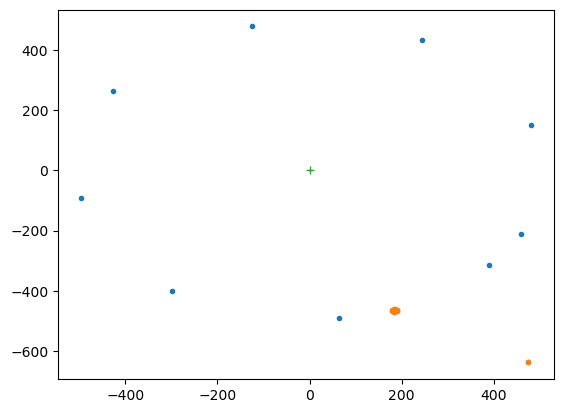

In [38]:
rft50 = sfts[5, :]
plt.plot(rft50.real, rft50.imag, '.')
for i in range(10):
    rft50[i] = sfts[5, i] * ephi[i]
plt.plot(rft50.real, rft50.imag, '.')
plt.plot(0, 0, '+')

SO, apart from the inexplicable first point we have rotated all the points to the same angle (the orange blob). Now when we sum the Fourier coefficients and take the magnitude we get

In [39]:
print(np.absolute(np.sum(rft50)))

5273.354039710348


which is far more believable for the intensity from the full transform

In [40]:
print(np.absolute(fft[48:53]))
print(freq[48:53])

[ 296.22445051  432.28245589  795.12715609 4786.53768459 1200.60288953]
[46.875     47.8515625 48.828125  49.8046875 50.78125  ]


So the quadrature sum of the last three terms is 

In [41]:
print(np.sqrt(np.conj(fft[50]) * fft[50] + np.conj(fft[51]) * fft[51] + np.conj(fft[52]) * fft[52]))

(4998.461513171594+3.818476328011209e-14j)


So, close; but the stupid first value is messing with the details. Still, we are WAY closer than the value of

In [42]:
print(np.absolute(fsums[5]))

795.1271560927712


that we obtained from the un-cohered sum.

This illustrates the general principle of combining data from a number of short Fourier transforms to achieve the same signal-noise ratio for a constant frequency signal that you would get from doing the single long transform, albeit with only the resolution of the short transform. I don't know of a way to recover the much higher frequency resolution of the longer transform.